# PROJECT TITLE 2: CDNOW SIMULATION

HUYNH THI THU TRANG A0184531H<br> 

CHEUNG ANSTEY       A0203165R<br> 

HUYNH THANH DUC ANH A0161312X<br>

VESSHNU SUTHARSAN   A0167302M<br> 

## Contents <a id='top'></a>
1. <a href=#intro>Introduction</a>
1. <a href=#simulate>Simulation Model</a>
1. <a href=#marketing>Marketing Strategies</a>
    1. <a href=#repeated>Increase Repeated Customers</a>
    1. <a href=#new>Increase New Customers</a>    
1. <a href=#52weeks>Further Refinement: 52 weeks</a>

<a id='intro'></a>
## Introduction

A promotional email or post is a commercial advertisement offering incentives to drive sales, resulting in profit for a business. The main goal of this form of email marketing is to convince customers to make a purchase. Using a simple stochastic model of buyer behavior based on "Forecasting Repeat Sales at CDNOW: A Case Study," from Fader and Peter, we simulate the impact of different types of these online campaigns on total sales. We use real purchase data from the online music retailer CDNOW to quantify the benefits.

<a id='simulate'></a>
## Simulation Model

1. Initialize the parameters and some given data, e.g new customers in each week over the course of 12 weeks and the total sales each week

In [212]:
import simpy
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.stats import binom, bernoulli, norm, expon, uniform, beta, geom

%matplotlib inline

In [388]:
#set the seed for random generator
np.random.seed(40)

#constants
aT = 6.901
bT = 7.185

aR = 5.024
bR = 5.595

gamma = 0.122

delta = -0.291

#information from the table in the study paper
total_customers = 23570

#to get the actual data value of new customers of each week, keep in mind it is the cumulative new customers ~
# ~ minus the sum of new customers from the previous weeks (data taken from the table)
new_customers = [1574, 1642, 1822, 1924, 2164, 2197, 2024, 2034, 2198, 2165, 2037, 1789]
actual_sales = [3627, 3857, 4512, 5054, 5843, 6456, 5906, 6077, 6757, 6848, 6770, 6781]
total_sales = np.array(actual_sales).sum()
weeks = list(range(12))

2. Model new customers buying behaviors. For new customers in each week, simulate the number of units they buy and compute the total sales throughout 12 weeks.

In [330]:
def trial_sales(new_customers, aT, bT, num_week=12):
    #Initialize list of new sales each week
    total_new=[]
    
    #compute new sales each week
    for week in range(12):
        #Initialize the total new sales i.e. resetting total new sales to 0 after each loop from the for loop
        total_new_week=0 

        #Simulate each new customer's behavior from new batch of customer each week
        ## cause the paper say use beta for qT variable
        for customer in range(new_customers[week]):          
            #Initialize the qT for each customer based on beta distribution
            qT=beta.rvs(aT, bT, size=1)
            #simulate unit boughts buy each customer based on geometric distribution
            ## cause the paper say use geometric for units sold
            unit_bought = geom.rvs(qT)
            #total new sales each week 
            total_new_week +=unit_bought
            
        total_new.append(total_new_week)
    return np.array(total_new) #return list of new sales each week

3. Model Repeated Sales. For each week, simulate the the number of customers in the previous week that will purchase again and simulate the number of units they will buy (if they decide to buy again).

In [331]:
def repeated_sales(new_customers, aR, bR, gamma, delta, num_week=12):
    #Initialize list of repeated sales each week
    total_repeated =[]
    for week in range(num_week):
        total_repeated_week = 0
        total_wek = 0
        
        if week > 0: #because in week 1, i.e. index 0 there should be no repeated customers
            pre_week = week if week <=11 else 12 #if computing repeated sales of a period more than 12 weeks, the customer is still from in week 1-12
            
            for wek in range(pre_week):
                #the formula below was from the paper
                pi = 1- gamma*((week-wek)**delta) #the prob of 1 customer being out of the market
                
                #generate a list of which customer being out of the market (0) and who will keep buying (1) of each week
                ##The use of a n.random.choice([0, 1], size=new_customers[wek], p=[pi, 1-pi]) is to use a biased head and tail
                ### to get the number of repeated customers coming in per week
                #### Note: at this part it is the number of customers NOT number of units sold
                re_customer = np.random.choice([0, 1], size=new_customers[wek], p=[pi, 1-pi])
                #adding number of repeated customers for a given week
                re_customer = np.sum(re_customer)
                
                #simulate units bought by each repeated customer
                for customer in range(re_customer):
                    qR=beta.rvs(aR, bR, size=1)
                    unit_bought = geom.rvs(qR)-1
                    total_wek += unit_bought
                    
        total_repeated.append(total_wek) 
    return np.array(total_repeated) #return the list of repeated sales

4. Compute new sales and repeated sales in each week. Run this simulation for 10 times to get the confidence interval of the simulation (can make it run for 500 times but it will take extremely long).

In [347]:
total_nr=np.zeros(12)
num_sim = 10

for s in range(num_sim):
    #compute new sales and repeated sale each week
    total_new=trial_sales(new_customers, aT= 6.901, bT=7.185)
    total_repeated=repeated_sales(new_customers, aR = 5.024, bR = 5.595, gamma = 0.122, delta = -0.291)
    
    #recall in the previous portion they total_new to represent new sales and total_repeated to represent returning customers
    ## total sales of each week would therefore be sum of each week's new and returning
    total_sale= total_new+total_repeated
    
    total_nr += total_sale #sum up total sales of each simulation
    
total_nr = total_nr/num_sim #divide buy the number of simulation to get the mean

5. Plot the simulation and the actual data and compare between them

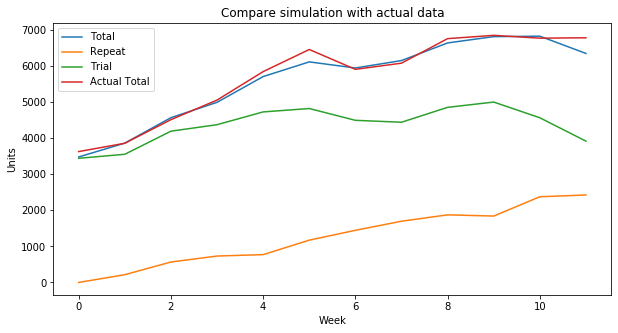

In [349]:
plt.figure(figsize =[10, 5])
x1 = weeks
y1 = total_nr
# plotting the the simulation total sales
plt.plot(x1, y1, label = "Total")

x2 = weeks
y2 = total_repeated
# plotting the simulation repeated sales 
plt.plot(x2, y2, label = "Repeat")

x3 = weeks
y3 = total_new
# plotting the simulation new sales 
plt.plot(x3, y3, label = "Trial")

x4 = weeks
y4 = actual_sales
# plotting the actual data: total sales
plt.plot(x4, y4, label = "Actual Total")

plt.xlabel('Week')
plt.ylabel('Units')
plt.title('Compare simulation with actual data')
plt.legend()
plt.show()

#### CONCLUSION:
As seen in the graph, the simulated total sales line (blue line) closely follows the actual (red line), indicating that this simulation model is reliable for predicting future sales and customer behaviors. Therefore, the simulated repeated sales and new sales can reflect the actual repeated sales and new sales, and we can use these simulation results to evaluate our marketing strategies.

<a id='marketing'></a>
## Marketing strategies

<a id='repeated'></a>
1. FIRST STRATEGY: Increase the number of repeated customers, this can be done by:

    * Sending promotion emails to encourage past customers to come back to the store
    * Giving free shipping for loyalty customers who come to the store for more than 2 times to encourage them to keep visisting
    * Sending recommendations for past customers to keep them being involved in the business
    
    With the above retention programs, we believe that:

    * The probability of past customers being out of the market will decrease, which means the gamma (the parameter affecting the probability of one previous customer being out of the market) increases. To evaluate the effect of this to the total sales, we decide to run the simulation with increasing gamma, from 0.122 to 0.2.
    
    * Returning rate of customers through email/membership promotions will improve, which means a higher delta value. To evaluate the effect of this to the total sales, we increase the delta value from negative value -0.291 to positive value 0.25.
        

a. Simulate repeated sales with modification to gamma and delta

In [385]:
# initilize the total sales with modification to the repeated sales due to gamma
total_r_gamma =np.zeros(12)

#run the simulation for num_sim times
for s in range(num_sim):
    
    #total new sales remain the same 
    total_new=trial_sales(new_customers, aT= 6.901, bT=7.185)
    #increasing gamma from 0.122 to 0.2
    total_repeated_r_gamma =repeated_sales(new_customers, aR = 5.024, bR = 5.595, gamma = 0.2, delta = -0.291) 
    total_sale= total_new+total_repeated_r_gamma
    
    total_r_gamma += total_sale
    
total_r_gamma = total_r_gamma/num_sim

In [386]:
# initilize the total sales with modification to the repeated sales due to delta
total_r_delta =np.zeros(12)

#run the simulation for num_sim times
for s in range(num_sim):
    
    #total new sales remain the same 
    total_new=trial_sales(new_customers, aT= 6.901, bT=7.185)
    #increasing gamma from -0.291 to 0.25
    total_repeated_r_delta =repeated_sales(new_customers, aR = 5.024, bR = 5.595, gamma = 0.122, delta = 0.25) 
    total_sale= total_new+total_repeated_r_delta
    
    total_r_delta += total_sale
    
total_r_delta = total_r_delta/num_sim

b. Plot simulated repeated sales with modification to gamma and delta

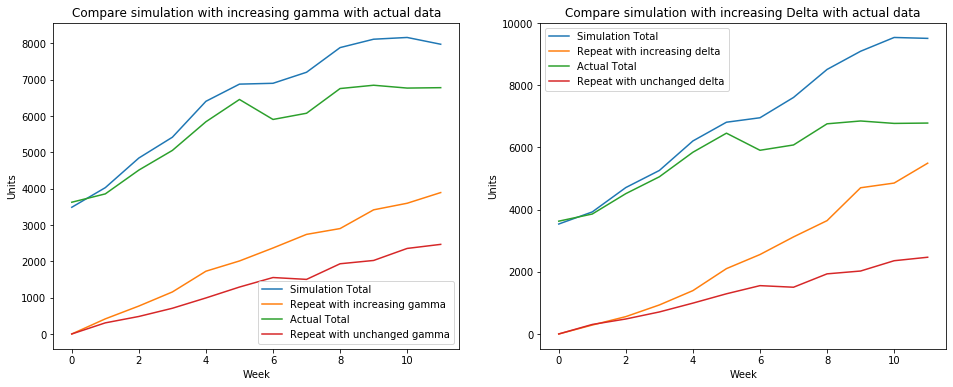

In [382]:
plt.figure(figsize= [16 , 6])

plt.subplot(121)
x1 = weeks
y1 = total_r_gamma
# plotting the the simulation total sales
plt.plot(x1, y1, label = "Simulation Total")

x2 = weeks
y2 = total_repeated_r
# plotting the simulation repeated sales 
plt.plot(x2, y2, label = "Repeat with increasing gamma")

x4 = weeks
y4 = actual_sales
# plotting the actual data: total sales
plt.plot(x4, y4, label = "Actual Total")

x5 = weeks
y5 = total_repeated
# plotting the simulation repeated sales with unchanged gamma
plt.plot(x5, y5, label = "Repeat with unchanged gamma")
plt.xlabel('Week')
plt.ylabel('Units')
plt.title('Compare simulation with increasing gamma with actual data')
plt.legend()

plt.subplot(122)
x1 = weeks
y1 = total_r_delta
# plotting the the simulation total sales
plt.plot(x1, y1, label = "Simulation Total")

x2 = weeks
y2 = total_repeated_r_delta
# plotting the simulation repeated sales 
plt.plot(x2, y2, label = "Repeat with increasing delta")

x4 = weeks
y4 = actual_sales
# plotting the actual data: total sales
plt.plot(x4, y4, label = "Actual Total")

x5 = weeks
y5 = total_repeated
# plotting the simulation repeated sales with unchanged gamma
plt.plot(x5, y5, label = "Repeat with unchanged delta")

plt.xlabel('Week')
plt.ylabel('Units')
plt.title('Compare simulation with increasing Delta with actual data')
plt.legend()
plt.show()

In [384]:
#difference between actual repeated sales and repeated sales with increasing gamma and delta
repeated_difference_gamma = (total_r_gamma-np.array(actual_sales)).sum()
repeated_difference_delta = (total_r_delta-np.array(actual_sales)).sum()
print(repeated_difference_gamma/total_sales, repeated_difference_delta/total_sales)

0.1288021259198692 0.19183506599696296


#### Conclude:
Both ways help to increase the total sales significantly, ~13% and ~20%. By changing the gamma, we only prevent the customers from being out of the market. But by changing the delta from negative value to positive value, we observe a new trend which is that, the further the given week is from the week a customer make the first purchase, the more likely they will buy again, so the number of repeated customers will increase over time with delta being positive. And this can be achieved by an effective and creative marketing campaign.

<a id='new'></a>
2. SECOND STRATEGY: Increase the number of new customers each week, this can be done by:

    * Advertising on major social media platforms
    * Reference programs, giving promotions to to existing customers who recommend the store to their friends
    * Giving promotions to first-time customers

With above suggestions, we believe that the new customers  in each week can be increased by 20%. To evaluate how effective the increasing new customers is to the total sales, we decide to run the simulation with increasing new customers, by a difference of 20% from the real data and compare the results to the actual data. 
 

In [391]:
increase_new_customers = (np.array(new_customers)* 1.2).astype(int) #increase 20 % for each week

In [350]:
total_n=np.zeros(12)

for s in range(10):
    total_new_n=trial_sales(increase_new_customers, aT= 6.901, bT=7.185)
    #increasing gamma from 0.122 to 0.2
    total_repeated=repeated_sales(new_customers, aR = 5.024, bR = 5.595, gamma = 0.122, delta = -0.291) 
    total_sale= total_new_n+total_repeated
    total_n += total_sale
total_n = total_n/10

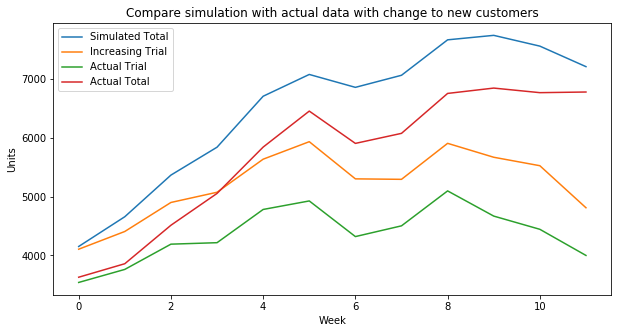

In [392]:
plt.figure(figsize=[10,5])
x1 = weeks
y1 = total_n
# plotting the the simulation total sales
plt.plot(x1, y1, label = "Simulated Total")

x5 = weeks
y5 = total_new_n
# plotting the the simulation new sales with inceasing customers
plt.plot(x5, y5, label = "Increasing Trial")

x3 = weeks
y3 = total_new
# plotting the simulation new sales 
plt.plot(x3, y3, label = "Actual Trial")

x4 = weeks
y4 = actual_sales
# plotting the actual data: total sales
plt.plot(x4, y4, label = "Actual Total")

plt.xlabel('Week')
plt.ylabel('Units')
plt.title('Compare simulation with actual data with change to new customers')
plt.legend()
plt.show()

In [380]:
#difference between actual new sales and new sales with increasing customers
new_difference = (total_n-actual_sales).sum()
new_difference/total_sales

0.1377452984464432

#### Conclude: 
By increasing the number of new customers in each week by 20%, we increase the total sales by ~13.7%.

Proper marketing strategies would allow for a proportionate increase in total sales and sales figure due to a wider exposure of audience.

Though email promotion may be an effective way of marketing in the time context(year-2000) of the research paper, this may not be as effective in current context where more effective and targeted marketing strategies has been developed.One such strategy we explored is promotional post on social media sites targeted at a target audience group which is already interested in a vintage lifestyle. This group of people are more likely to be receptive to marketing campaigns of CD, a vintage product in today’s context. The employment of this marketing strategy is therefore likely to bring on more new customers.



<a id='52weeks'></a>
## Further refinement: Simulation for 52 weeks

1. After cleaning the CDNOW full raw data from a text file, we exported it to CDNOW Edited.csv file. Then we imported this file to get the actual total sales for 52 weeks.

In [361]:
#CDNOW Edited contains Customer_ID, the date they buy and how many units per purchased
cd= pd.read_csv('CDNOW Edited.csv')

#convert 'Date' column of cd dataframe into pandas datetime object
cd['Date']=pd.to_datetime(cd['Date bought'])

#using the date extracted to get Customer_ID, Units bought and date into a new dataframe called dataa, getting records from 1997 only (52 weeks)
dataa = cd[cd['Date'].dt.year==1997][['Customer_ID', 'Units bought', 'Date']].reset_index()
cdnow = dataa.drop('index', axis=1)

#editing the "Week" column to contain the exact week that a customer came to buy CD(s)
## the iso.calender() function return 3 parts [0]=year, [1]=week, [2]=day in the week, i.e. 1 for monday, 4 for thursday etc.
cdnow['Week']=0
for i in range(len(dataa['Date'])):
    cdnow['Week'][i]=dataa['Date'][i].isocalendar()[1]

actual_total_52 = cdnow.groupby('Week')['Units bought'].sum() #getting total sales each week over the course of 52 weeks

C:\Users\-\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


2. Simulate the total sales for 52 weeks with the same logic, same distribution as the simulation for 12 weeks.

In [365]:
#initialize average simulation total sales result of 52 weeks
total_52 = np.zeros(52)

#run the simulation for num_sim times
for s in range(num_sim):
    
    #same new sales because the record only tracked the purchase of new customers in the first 12 weeks of 1997
    total_new_52=trial_sales(new_customers, aT= 6.901, bT=7.185)
    #change num_week from 12 to 52
    total_repeated_52 = repeated_sales(new_customers, aR = 5.024, bR = 5.595, gamma = 0.122, delta = -0.291, num_week=52)
    total_sale_52 =np.append(total_new_52 + total_repeated_52[:12], total_repeated_52[12:])
    
    total_52 += total_sale_52

total_52 /=num_sim

# again, the above code is exactly the same from total_new and total_repeated from before
## same logic, same equation and same data distributions
### only difference for this is the use of predicting sales to 52 weeks rather than 12

3. Compare the predicting total sales with the actual total sales

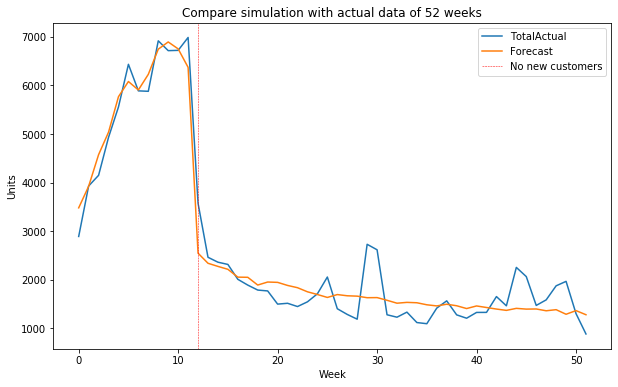

In [389]:
plt.figure(figsize=[10, 6])
plt.plot(list(range(52)), actual_total_52, label= 'TotalActual')
plt.plot(list(range(52)), total_52, label= 'Forecast')
plt.axvline(x=12, ymin=0, label='No new customers', color='r', linestyle='--', linewidth=0.5)

plt.xlabel('Week')
plt.ylabel('Units')
plt.title('Compare simulation with actual data of 52 weeks')
plt.legend()
plt.show()

Because we build the model based on purchasing behaviour in the first 12 weeks of 1997, we get the negative delta values, leading to the fact that repeated customers decrease over time. Therefore, when simulating units bought by repeated customers (whose first purchase is in the first 12 weeks) over the course of a year, we see a gradual decrease in total CD units sold, indicating a decrease in repeated customers.

However, we can see several spikes in actual sales during the year that the simulation fails to capture. This is understandable because our model does not take into account promotional and seasonal events.